<a href="https://www.kaggle.com/code/syerramilli/ps3e9-keras-mlp-with-skip-connections?scriptVersionId=121564541" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


In [2]:
# install alepython library for visualizing feature effects
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-7l1yxit1/alepython_cfff67703b284b64adcdc9764107d18e
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-7l1yxit1/alepython_cfff67703b284b64adcdc9764107d18e
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15036 sha256=8f58e32f2279d07950d686df0746ff8d06bff9d5837fd22750c076ff94854fa9
  Stored in directory: /tmp/pip-ephem-wheel-cache-sy6flh22/wheels/80/bf/e2/38bec5b394c0415f9afbe31d3d4b01aa327546ca4f109e06cc
Successfully built alepython


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')
del train['id']

train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61


## Visualization and preprocessing


There are a few duplicates in the training set. We will remove the duplicates by averaging the response across the duplicates

In [5]:
predictors = train.columns[:-1].to_list()
train = train.groupby(predictors).agg('mean').reset_index()

<AxesSubplot:>

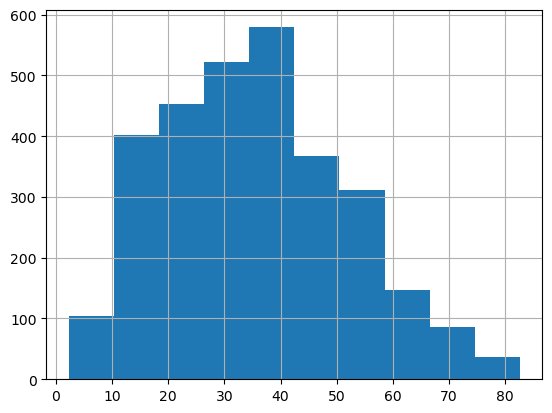

In [6]:
train['Strength'].hist()

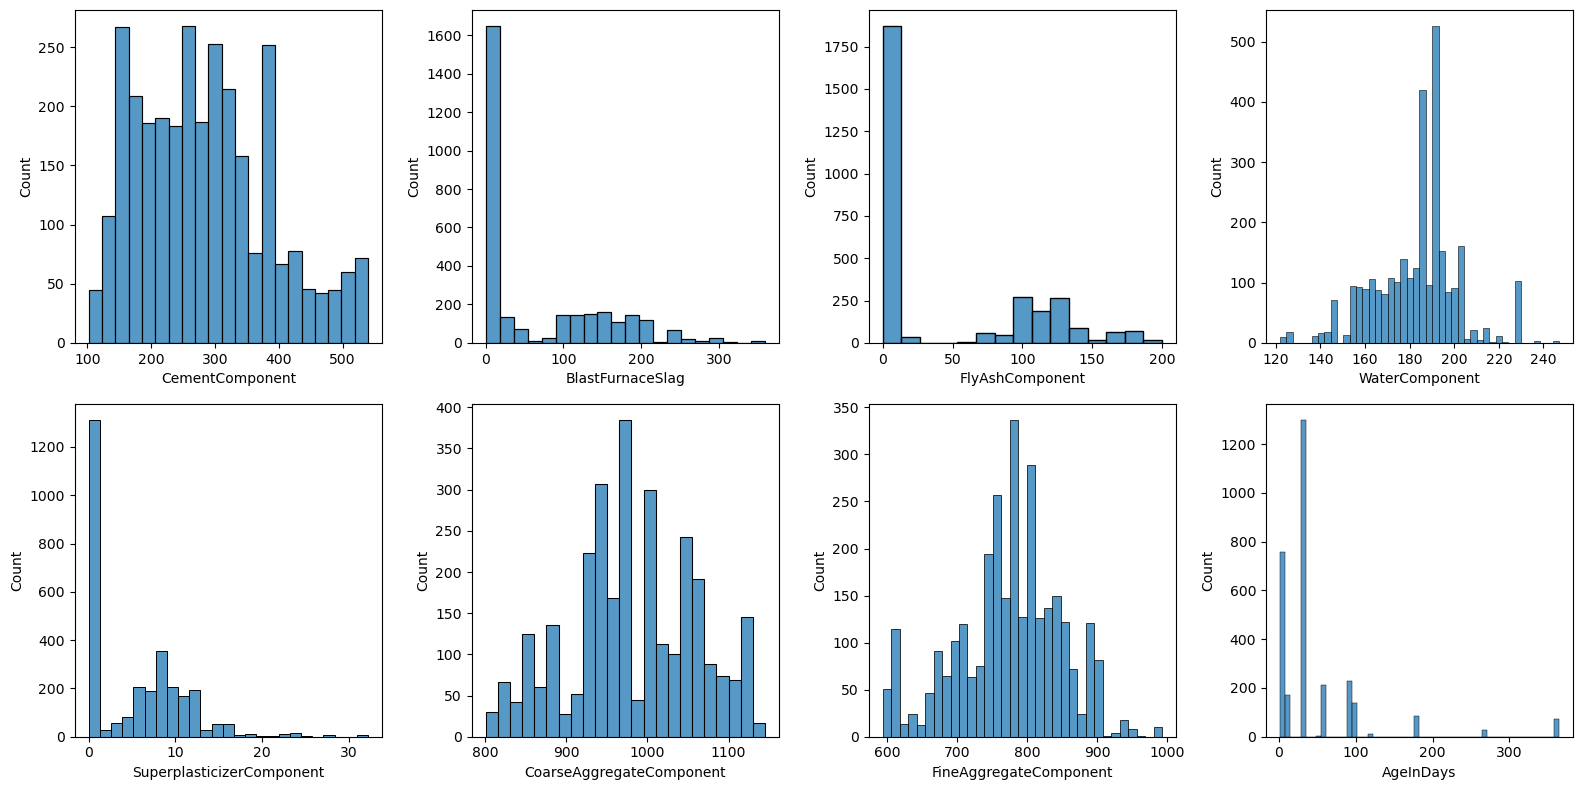

In [7]:
# histograms of predictors
n_rows = 2
n_cols = 4

fig,axs = plt.subplots(n_rows,n_cols,figsize=(4*n_cols,4*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_idx = n_cols*i+j
        _ = sns.histplot(data=train,x=train.columns[col_idx],ax=axs[i][j])
        
fig.tight_layout()

We will apply a log-transform to the `AgeInDays` predictor

In [8]:
train['AgeInDays'] = np.log(1+train['AgeInDays'])
test['AgeInDays'] = np.log(1+test['AgeInDays'])

Some of the predictors have a rather larger number of zero values. 

In [9]:
zero_value_cols = ['BlastFurnaceSlag','FlyAshComponent','SuperplasticizerComponent']
for col in zero_value_cols:
    print('Proportion of zero_values observations for col %s: %5.3f' %(col,(train[col]==0).mean()))

Proportion of zero_values observations for col BlastFurnaceSlag: 0.537
Proportion of zero_values observations for col FlyAshComponent: 0.623
Proportion of zero_values observations for col SuperplasticizerComponent: 0.437


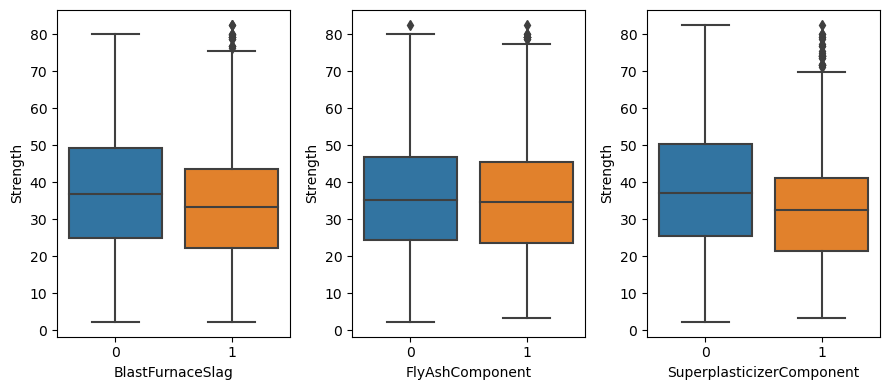

In [10]:
fig,axs = plt.subplots(1,len(zero_value_cols),figsize=(3*len(zero_value_cols),4))
for i,col in enumerate(zero_value_cols):
    indicator = 1*(train[col] == 0)
    _ = sns.boxplot(y=train['Strength'],x=indicator,ax=axs[i])

fig.tight_layout()

Only SuperplasticizerComponent==0 seems to have some effect on the response. We will add an indicator variable for this. 

In [11]:
from sklearn.preprocessing import StandardScaler


input_sc = StandardScaler()
output_sc = StandardScaler()

X = input_sc.fit_transform(train.drop('Strength',axis=1).values)
y = output_sc.fit_transform(train[['Strength']].values).ravel()
original_std = output_sc.scale_


# add indicator variable for SuperplasticizerComponent==0
X = np.concatenate(
    [X,1*(train['SuperplasticizerComponent']==0).values.reshape(-1,1)],axis=-1
)

## Single layer feed forward network with skip connections

The architecture consists of a single hidden layers and residual connections from the inputs to the response to model linear effects. 
- From the partial dependence plots from a XGBoost model trained on the same data (https://www.kaggle.com/code/syerramilli/ps3e9-xgboost-hyperopt?scriptVersionId=121345149&cellId=25), there seem to be a few linear effects. 
- In my previous attempts with a larger architecture, from the accumulated local effects (ALE) plots ((https://www.kaggle.com/code/syerramilli/ps3e9-keras-mlp-with-skip-connections?scriptVersionId=121509948&cellId=27), the response depended logarthmically on `AgeInDays` and largely linearly on the others. 


Since we are taking a log-transform of the Age, we should expect the most of the large effects to be linear for the most part. We will verify this using ALEPlots on the final model. Note that there may be interaction effects among the different predictors.

In [12]:
import tensorflow as tf
import keras
from tensorflow_addons.optimizers import AdamW
from sklearn.model_selection import train_test_split

from typing import Dict, Optional

In [13]:
def construct_model(params:Dict) -> keras.Model:
    """
    Build a single hidden layer MLP with residual connections and weight decay regularization
    
    Arguments
    ---------
    params: dict
        Dictionary containing the hyperparameters of the model including learning rates
        and weight decay regularization
        
    Returns
    ---------
    model: keras.Model
        A compiled keras model
    """
    n_hidden = 1 # TODO: use this as a hyperparameter
    n_hidden_list = [params['hsize%d'%i] for i in range(1,n_hidden+1)]
    #dropouts_list = [params['dropout%d'%i] for i in range(1,n_hidden+1)]
    
    inputs = keras.Input(shape=(X.shape[-1],))

    mlp = inputs
    for i in range(n_hidden):
        if params['activation'] == 'selu':
            mlp = keras.layers.Dense(n_hidden_list[i],activation='selu',kernel_initializer='lecun_normal')(mlp)
            #mlp = keras.layers.AlphaDropout(dropouts_list[i])(mlp)
        else:
            mlp = keras.layers.Dense(n_hidden_list[i],activation=params['activation'])(mlp)
    
    # concatenate input with the mlp_output
    combined_representation = keras.layers.concatenate([inputs,mlp])
    
    final_output = keras.layers.Dense(1)(combined_representation)
    
    # final model
    model = keras.Model(inputs,final_output)

    model.compile(
        #optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        optimizer=AdamW(learning_rate=params['learning_rate'],weight_decay=params['weight_decay']),
        loss='mean_squared_error'
    )

    return model


def build_and_fit(
    params:Dict,X:np.ndarray,y:np.ndarray,
    verbose:bool=False,
    resample_seed:Optional[int]=None
) -> keras.Model:
    #further divide into train and validation splits for early stopping
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.1,random_state=resample_seed)
    
    EPOCHS = 100
    BATCH_SIZE = params['batch_size']
    
    # callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=verbose,
        patience=15,
        restore_best_weights=True
    )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        verbose=verbose,
        patience=5,
        factor=params['reduce_lr_factor'],
        min_lr = 1e-5
    )
        
    # create model
    model = construct_model(params)

    # train model
    _ = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping,reduce_lr],
        validation_data=(X_val, y_val),
        verbose=False,
    )

    return model

### Hyperparameter tuning

We will use the hyperopt library to tune the hyperparameters

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe,space_eval
from hyperopt.pyll_utils import scope

In [15]:
# generate train_test_splits
splits = list(KFold(n_splits=8,shuffle=True,random_state=1).split(X,y))
len(splits)

8

In [16]:
def fit_and_test_fold(params:Dict,train_index:np.ndarray,test_index:np.ndarray) -> float:
    X_train = X[train_index,...]; X_test = X[test_index,...]
    y_train = y[train_index]; y_test = y[test_index]
    
    
    model = build_and_fit(params,X_train,y_train)

    # obtain test predictions
    test_preds = model.predict(X_test,verbose=False).ravel()
    
    # return RMSE
    return np.sqrt(mean_squared_error(y_test,test_preds))*original_std

def objective(params:Dict) -> Dict:
    tf.keras.backend.clear_session()
#     cv_losses = [None]*len(splits)
#     for i,(train_index,test_index) in enumerate(splits):
#         cv_losses[i] = fit_and_test_fold(params,train_index,test_index)
    
    # NOT using GPU in this notebook
    cv_losses = Parallel(n_jobs=4,verbose=0)(
        delayed(fit_and_test_fold)(params,train_index,test_index) for train_index,test_index in splits
    )
    
    return {'loss':np.mean(cv_losses),'status': STATUS_OK,'min_RMSE_fold':np.min(cv_losses),'max_RMSE_fold':np.max(cv_losses)}

search_space = {
    'hsize1': scope.int(hp.quniform('hsize1',2,150,1)),
    #'hsize2': scope.int(hp.quniform('hsize2',2,150,1)),
    #'dropout1': hp.uniform('dropout1',0.01,0.5),
    #'dropout2': hp.uniform('dropout2',0.01,0.5),
    'activation': hp.choice('activation',['relu','selu','tanh','softplus']),
    'learning_rate': hp.loguniform('learning_rate',np.log(1e-4),np.log(0.1)),
    'batch_size':scope.int(hp.quniform('batch_size',32,1024,1)),
    'weight_decay':hp.loguniform('weight_decay',np.log(1e-8),np.log(0.1)),
    'reduce_lr_factor': hp.uniform('reduce_lr_factor',0.1,0.5), # factor of 2-10
}

trials = Trials()
best = fmin(
    objective,search_space,
    algo=tpe.suggest,
    max_evals = 100,
    trials=trials,
    return_argmin=False,
    rstate=np.random.default_rng(1)
)
best

 65%|██████▌   | 65/100 [14:33<07:09, 12.29s/trial, best loss: 12.007431189176229]

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



100%|██████████| 100/100 [22:10<00:00, 13.31s/trial, best loss: 12.002424143939502]


{'activation': 'selu',
 'batch_size': 177,
 'hsize1': 60,
 'learning_rate': 0.03199178538967799,
 'reduce_lr_factor': 0.2045753969606622,
 'weight_decay': 7.86335281639048e-08}

In [17]:
results = pd.DataFrame([
    space_eval(search_space,row.to_dict()) for _,row in pd.DataFrame(trials.vals).iterrows()
]) 
results['RMSE'] = [tmp['loss'] for tmp in trials.results]
results['min_RMSE_fold'] = [tmp['min_RMSE_fold'] for tmp in trials.results]
results['max_RMSE_fold'] = [tmp['max_RMSE_fold'] for tmp in trials.results]
results.to_csv('cv_rmse_hyperopt.csv',index=False)
# top 10 configurations
results.sort_values('RMSE',ascending=True).head(10)

,activation,batch_size,hsize1,learning_rate,reduce_lr_factor,weight_decay,RMSE,min_RMSE_fold,max_RMSE_fold
73,selu,177,60,0.031992,0.204575,7.863353e-08,12.002424,11.169401,12.675509
54,selu,39,13,0.013770,0.217966,8.678571e-08,12.007431,11.270858,12.524919
89,tanh,147,117,0.017659,0.316082,1.588735e-05,12.018938,11.192463,12.690344
75,relu,32,71,0.015171,0.224987,1.700956e-06,12.021202,11.431167,12.574433
28,selu,96,48,0.064312,0.124571,3.898771e-08,12.021733,11.153580,12.607549
90,tanh,289,145,0.026416,0.330905,2.298330e-05,12.022278,11.203902,12.957562
93,tanh,374,114,0.082651,0.378515,4.129076e-03,12.025860,11.228872,12.850486
26,selu,173,61,0.071848,0.100169,1.332480e-08,12.025913,11.305374,12.611599
71,selu,199,30,0.020066,0.188015,3.327667e-08,12.029266,11.171793,12.634882
65,selu,173,43,0.089613,0.102472,1.617228e-08,12.032163,11.304654,12.613773


## Final model

Rather than training a single model, we will train an ensemble of models, where each model is trained using a different training-validation split

In [18]:
keras.backend.clear_session()
n_ensemble = 10
models = [None]*n_ensemble

for i in range(n_ensemble):
    print(f'********* Model {i+1} *********')
    models[i] = build_and_fit(best,X,y,verbose=True,resample_seed=i)
    print()

********* Model 1 *********

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.006544731815031136.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0013388911516126264.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00027390417886949327.
Restoring model weights from the end of the best epoch: 11.

Epoch 26: ReduceLROnPlateau reducing learning rate to 5.603405657475678e-05.
Epoch 26: early stopping

********* Model 2 *********

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.006544731815031136.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0013388911516126264.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00027390417886949327.
Restoring model weights from the end of the best epoch: 14.

Epoch 29: ReduceLROnPlateau reducing learning rate to 5.603405657475678e-05.
Epoch 29: early stopping

********* Model 3 *********

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.006544731815031136.

Epoch 22: ReduceLROnPlateau reducing learni

In [19]:
# Create ensemble model in Keras
model_input = tf.keras.Input(shape=(X.shape[1],))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

print(ensemble_model.summary())

ensemble_model.save('ensemble_model.h5')

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 model (Functional)             (None, 1)            670         ['input_11[0][0]']               
                                                                                                  
 model_1 (Functional)           (None, 1)            670         ['input_11[0][0]']               
                                                                                                  
 model_2 (Functional)           (None, 1)            670         ['input_11[0][0]']               
                                                                                           

## ALE plots for visualizing feature effects

We added residual connections from the inputs to the outputs to directly model any linear effects. Let's visualize the effects of the individual predictors using ALE plots (https://academic.oup.com/jrsssb/article/82/4/1059/7056085). The ALE plots can be used for
1. interpreting the individual effects of the predictors - e.g.: linear vs non-linear, monotonic vs non-monotonic, quadratic, etc.
2. determining the most influential predictors. The influence can be estimated through the range of y-axis values in each plot. The larger the range, the larger the effect.

We will be using the `alepython` library for generating ALE plots. The library is not posted to the offical PyPi repository, but is available from Github (https://github.com/blent-ai/ALEPython) and we have installed it earlier. The default plot function from this library has limited customizability. We will therefore manually extract and plot the computed ALE values. The cell below contains utility scripts for generating the 1st order ALE effects.

In [20]:
from alepython.ale import _first_order_ale_quant
from typing import Callable,Iterable,Union

def first_order_aleplot_quant(
    predictor:Callable,
    train_data:pd.DataFrame,
    feature:str,
    ax:plt.Axes,
    bins:int=10,
    **kwargs):
    '''
    Plot and return the first-order ALE function for a continuous feature.

    Arguments
    ---------
    predictor: callable
        The prediction function. For scikit-learn regressors, pass the `.predict`
        method. For scikit-learn classifiers, either pass the `.predict_proba` method
        or pass a custom log-odds function. For other pass a custom predict function
        that takes in a pandas dataframe as input
    
    train_data: pd.DataFrame
        Training data on which the model was trained. Cannot pass numpy ndarrays.
    
    feature: str
        Feature name. A single column label
    
    ax: matplotlib.axes.Axes
        Pre-existing axes to plot onto
    
    bins : int
        This defines the number of bins to compute. The effective number of bins may
        be less than this as only unique quantile values of train_data[feature] are
        used.
    
    **kwargs: plot properties, optional
        Additional keyword parameters passed to `ax.plot`.
    
    Returns
    ---------
    ax: matplotlib.axes.Axes
        The matplotlib axes containing the plot
    
    ale: np.ndarray
        first order ALE
    
    quantiles: np.ndarray
        The quantiles used
    '''

    ale,quantiles = _first_order_ale_quant(predictor,train_data,feature,bins)
    bin_centers = 0.5*(quantiles[:-1]+quantiles[1:])
    _ = ax.plot(bin_centers,ale,**kwargs)
    _ = sns.rugplot(train_data[feature],ax=ax,color='k',alpha=0.2)
    _ = ax.grid(linestyle="-", alpha=0.4)
    _ = ax.set_xlabel(feature)
    _ = ax.set_ylabel(r'$f_1$(%s)'%feature)
    return ax,ale,quantiles


def keras_data_frame_predict(
    data:pd.DataFrame) -> np.ndarray:
    '''
    Convenience prediction to generate predictions from a keras model on 
    a pandas DataFrame object. The data is assumed to be preprocessed.
    '''
    
    data_numpy = data.values
    return ensemble_model.predict(data_numpy,verbose=0).ravel()

The first-order ALE plots for the original 8 predictors are shown below. When I ran the notebook with limited hyperparameter tuning, the most important predictors (in decreasing order of influence) were `LogAgeInDays` (monotonically increasing, largely linear), `CementComponent` (monotinically increasing, largely linear), and `WaterComponent` (monotonically decreasing, largely linear for the most part before flatenning out). The results can change in the final saved version after more extensive hyperparameter tuning.  

**Note:** The x-axis for each variable is in standardized units.

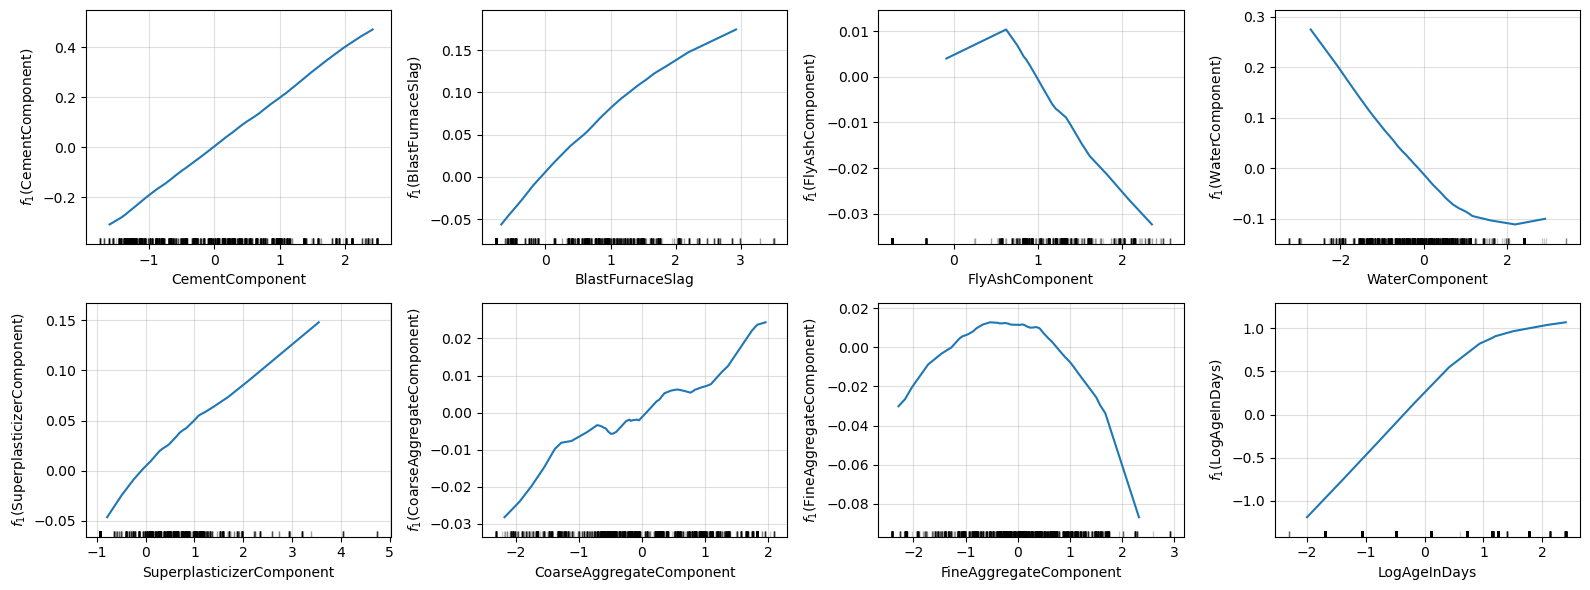

In [21]:
X_cols = train.drop('Strength',axis=1).columns.tolist()
X_cols[-1] = 'Log'+X_cols[-1]
X_cols.append('SuperplasticizerComponent_is_zero')
X_dat = pd.DataFrame(X,columns = X_cols)

num_rows=2
num_cols=4

fig,axs = plt.subplots(num_rows,num_cols,figsize=(16,6))
for i in range(num_rows):
    for j in range(num_cols):
        # select correct feature
        feature = X_dat.columns[num_cols*i + j]
        _ = first_order_aleplot_quant(keras_data_frame_predict,X_dat,feature,bins=50,ax=axs[i,j])

fig.tight_layout()

## Generate test predictions

In [22]:
X_test = input_sc.transform(test.drop('id',axis=1).values)
X_test = np.concatenate([
    X_test,1*(test['SuperplasticizerComponent']==0).values.reshape(-1,1)
],axis=-1)
y_test_pred = ensemble_model.predict(X_test)

y_test_pred_orig = output_sc.inverse_transform(y_test_pred.reshape(-1,1)).ravel()

submission = pd.DataFrame({'id':test['id'].values,'Strength':y_test_pred_orig})
submission.to_csv('submission.csv',index=False)

113/113 [==============================] - 0s 2ms/step
